In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
import pandas as pd
import numpy as np
import os
import csv
import math
import random

from torchsummary import summary
from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset
from torch.optim.lr_scheduler import LambdaLR
from torch import nn, optim, tensor, Tensor
from sklearn.preprocessing import RobustScaler, StandardScaler

In [38]:
random.seed(52)

In [39]:
class CandlesDataset(Dataset):
    def __init__(self, root_dir: str, years: list, window_size: int, max_samples: int, device):
        self.device = device
        self.window_size = window_size
        self.tables_list = self.__get_correct_tables(root_dir, years)
        self.samples = self.__generate_samples(self.tables_list, max_samples)

    def __get_correct_tables(self, root_dir, years):
        """
        get paths of .csv with len > window_size 
        """
        tables_list = []
        for root, dirs, files in os.walk(root_dir):
            if dirs:
                tables_dirs = dirs
                break
        for table_dir in tables_dirs:
            if int(table_dir[-4:]) in years:
                full_dir = os.path.join(root_dir, table_dir)
                for root, dirs, files in os.walk(full_dir):
                    for file in files:
                        if file.lower().endswith('.csv'):
                            full_path = os.path.join(full_dir, file)
                            with open(full_path) as f:
                                if sum(1 for line in f) > self.window_size:
                                    tables_list.append(full_path)
        random.shuffle(tables_list)
        return tables_list

    def __generate_samples(self, tables_list, max_samples):
        samples = torch.empty((0, self.window_size + 1, 8)) #(n_blocks, window_size, n_features)
        for table in tqdm(tables_list[:max_samples], desc="tables done"):
            df = pd.read_csv(
                table,
                sep =";",
                names=["figi", "utc", "open", "close", "high", "low", "volume"],
                index_col=False
                )
            df['utc'] = pd.to_datetime(df['utc'], utc=True)

            #fill missing candles
            df = df.set_index('utc').resample('min').asfreq()
            df['volume'] = df['volume'].fillna(0)
            for col in ['figi', 'open', 'high', 'low', 'close']:
                df[col] = df[col].ffill()

            #add time data
            df['hour'] = df.index.hour
            df['day_of_week'] = df.index.day_of_week
            df['minute'] = df.index.minute
            df.drop(labels=['figi'], axis=1, inplace=True)

            df = df[(df['day_of_week'] < 5)] #drop not tradeble days

            data = df.values
            if data.shape[0] == 0:
                continue
            scaler = RobustScaler()
            data = scaler.fit_transform(data)
            windows = np.lib.stride_tricks.sliding_window_view(
                data, (self.window_size + 1, data.shape[1])
            )  #(n_blocks, window_size, n_features)
            tensor = torch.tensor(windows, dtype=torch.float32).squeeze(dim=1)
            samples = torch.vstack([samples, tensor])
        return samples


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        return sample[:-1, :5], sample[:-1, 5:], sample[-1:, :5].squeeze(dim=0) #OHLCV, time features, target

In [40]:
class TimeEncoder(nn.Module):
    def __init__(self, candles_features: int, time_features: int, d_model: int):
        super().__init__()
        self.input_proj = nn.Linear(candles_features, d_model)
        self.time2vec = nn.Sequential(
            nn.Linear(time_features, 64),
            nn.GELU(),
            nn.Linear(64, d_model)
        )
        self.learnable_pe = nn.Parameter(torch.randn(1, 5000, d_model))
        
    def forward(self, x, time_features):
        t_emb = self.time2vec(time_features)
        x = self.input_proj(x)
        x = x + self.learnable_pe[:, :x.size(1), :] + t_emb
        return x

In [41]:
class Transformer(nn.Module):
    def __init__(self, d_model: int, nhead: int, encoder_layers: int):
        super().__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, batch_first=True),
            num_layers=encoder_layers
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

In [42]:
class CandleTransformer(nn.Module):
    def __init__(self, heads: int, encoder_layers: int, d_model: int):
        super().__init__()
        self.time_enc = TimeEncoder(candles_features=5, time_features=3, d_model=d_model)
        self.transformer = Transformer(d_model=d_model, nhead=heads, encoder_layers=encoder_layers)
        self.out = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
            )

    def forward(self, prices, time_feats):
        """
        # prices: [B, 180, 5] (OHLCV)
        # indicators: [B, 180, 4]
        # time_feats: [B, 180, 3]
        """
        time_encoded = self.time_enc(prices, time_feats)
        trans_out = self.transformer(time_encoded)
        trans_out = trans_out.mean(dim=1)
        out = self.out(trans_out)
        return out

In [43]:
def direction_accuracy(pred_close, true_close):
    direction_pred = torch.sign(pred_close[:, 3] - pred_close[:, 0]) # open - close
    direction_true = torch.sign(true_close[:, 3] - true_close[:, 0])
    return (direction_pred == direction_true).float().mean()

In [44]:
heads = 4
encoder_layers = 4
d_model = 256
batch_size = 64
window_size = 180
num_workers = 4
root_dir = 'market_data/unzip_data'
model_dir = 'checkpoints/'
max_samples_train = 1000
max_samples_val = 200
max_epoch = 20
years_train = [2023]
years_val = [2024]
model_path = os.path.join(model_dir, 'best.tar')
is_preload = False

In [45]:
train_dataset = CandlesDataset(
    root_dir=root_dir, 
    years=years_train, 
    window_size=window_size,
    max_samples=max_samples_train, 
    device=device
    )

val_dataset = CandlesDataset(
    root_dir=root_dir, 
    years=years_val, 
    window_size=window_size,
    max_samples=max_samples_val, 
    device=device
    )

tables done:   0%|          | 0/1448 [00:00<?, ?it/s]


In [46]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

[0.0001, 9.701478472890247e-05, 8.84191999343894e-05, 7.525e-05, 5.909558479451306e-05, 4.190441520548695e-05, 2.5750000000000013e-05, 1.2580800065610596e-05, 3.985215271097539e-06, 1e-06]


Text(0.5, 1.0, 'Learning Rate Schedule')

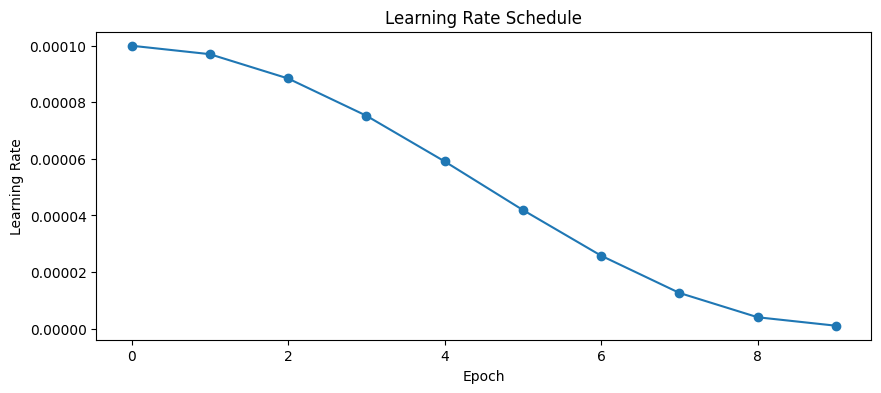

In [ ]:
LR_START = 1e-4
LR_MAX = 1e-4
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0

def lr_lambda(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = max_epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr / LR_START
    
# cosine sheduler

In [ ]:
def weighted_mse_loss(
        input, 
        target, 
        weights=torch.tensor([1.0, 1.0, 1.0, 1.0, 0.2]).to(device)
        ):
    return (weights * (input - target) ** 2).mean()

In [47]:
model = CandleTransformer(
    heads=heads,
    encoder_layers=encoder_layers, 
    d_model=d_model
    ).to(device=device)

criterion = weighted_mse_loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [ ]:
train_losses = []
val_losses = []
dir_accuracies = []
current_epoch = 0

if is_preload:
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    current_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    dir_accuracies = checkpoint['dir_accuracies']
    print('Preload model')

for epoch in range(current_epoch, max_epoch):
    model.train()
    running_loss = 0
    
    for candles, time, targets in tqdm(train_loader, desc=f"Train Epoch {epoch + 1}"):
        candles, time, targets = candles.to(device), time.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(candles, time)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * candles.size(0)
    train_loss = running_loss / len(train_dataset)

    model.eval()
    val_running_loss = 0
    all_targets = []
    all_preds = []
    with torch.no_grad():
        for candles, time, targets in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
            candles, time, targets = candles.to(device), time.to(device), targets.to(device)
            outputs = model(candles, time)
            val_running_loss += criterion(outputs, targets).item() * candles.size(0)
            all_preds.append(outputs.detach().cpu())
            all_targets.append(targets.detach().cpu())
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    val_loss = val_running_loss / len(val_dataset)

    dir_accuracy = direction_accuracy(all_preds, all_targets)
    dir_accuracies.append(dir_accuracy)

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'dir_accuracies': dir_accuracies
        }, os.path.join(model_dir, f'baseline_{epoch}.tar'))
    if len(val_losses) == 0 or val_loss < min(val_losses):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'dir_accuracies': dir_accuracies
            }, os.path.join(model_dir, f'best.tar'))
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step()
    print(f'LR: {current_lr:.4e}')
    print(f"Epoch {epoch+1}/{max_epoch}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}\n")
    print(f"Val direction Accuracy: {dir_accuracy:.4f}\n")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    dir_accuracies.append(dir_accuracy)

Train Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

In [29]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [31]:
for candles, time, targets in tqdm(train_loader, desc=f"Train Epoch {epoch + 1}"):
    optimizer.zero_grad()
    outputs = model(candles, time)
    loss = criterion(outputs, targets)
    print(outputs)
    print(targets)
    break

Train Epoch 20:   0%|          | 0/77530 [00:00<?, ?it/s]

tensor([[-0.0019,  0.0037, -0.0104, -0.0165,  0.9901]],
       grad_fn=<AddmmBackward0>)
tensor([[[ 0.1463,  0.1463,  0.0800,  0.2000, -0.2192]]])
